<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/Hiroshima_Univ_Topic_Modeling_HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第1回AI・データイノベーションセミナー 2021年3月11日（木曜日）

## トピックモデリングの実践

* トピックモデリングを、NMF(nonnegative matrix factorization)とLDA(latent Dirichlet allocation)とで実践してみる。
* いずれもscikit-learnの実装を使う。
* 各トピックの上位単語はワードクラウドで可視化する。

* 参考資料
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html



---



## 01 データセットの準備
* NeurIPSで発表された1,740本の論文の本文を使う。

### データをダウンロードしリスト化する関数を定義

* PATHで指定した場所に文書ファイルが配置される。

In [1]:
import io
import os.path
import re
import tarfile
import smart_open


PATH = './' # ここは適当に設定


def extract_documents(url='https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'):

  fname = os.path.join(PATH, url.split('/')[-1])

  if not os.path.isfile(fname):
    with smart_open.open(url, "rb") as fin:
      with smart_open.open(fname, 'wb') as fout:
        while True:
          buf = fin.read(io.DEFAULT_BUFFER_SIZE)
          if not buf:
            break
          fout.write(buf)

  with tarfile.open(fname, mode='r:gz') as tar:
  # Ignore directory entries, as well as files like README, etc.
    files = [
             m for m in tar.getmembers()
             if m.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', m.name)
             ]
    for member in sorted(files, key=lambda x: x.name):
      member_bytes = tar.extractfile(member).read()
      yield member_bytes.decode('utf-8', errors='replace')

* 実際にデータを取得しリスト化する

In [2]:
docs = list(extract_documents())

* 文書数、具体的な文書の内容などを確認

In [3]:
print(len(docs))

1740


In [4]:
print(docs[0][:1000])

1 
CONNECTIVITY VERSUS ENTROPY 
Yaser S. Abu-Mostafa 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
How does the connectivity of a neural network (number of synapses per 
neuron) relate to the complexity of the problems it can handle (measured by 
the entropy)? Switching theory would suggest no relation at all, since all Boolean 
functions can be implemented using a circuit with very low connectivity (e.g., 
using two-input NAND gates). However, for a network that learns a problem 
from examples using a local learning rule, we prove that the entropy of the 
problem becomes a lower bound for the connectivity of the network. 
INTRODUCTION 
The most distinguishing feature of neural networks is their ability to spon- 
taneously learn the desired function from 'training' samples, i.e., their ability 
to program themselves. Clearly, a given neural network cannot just learn any 
function, there must be some restrictions on which networks can learn which 
functions. One obv

### spaCyを使ってtokenizeする
* spaCyについては https://spacy.io/ を参照

* 前処理の高速化のためtaggerなどは無効にしておく

In [5]:
import spacy

nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

* テキストを小文字にしてからtokenizeする関数の定義

In [6]:
def spacy_lemmatize_text(nlp, text):
  text = nlp(text.lower())
  doc = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text]
  return [word for word in doc if len(word) > 1] # 長さ1の単語は削除

* tokenizationの実行

In [7]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  new_docs.append(spacy_lemmatize_text(nlp, doc))

100%|██████████| 1740/1740 [01:02<00:00, 27.90it/s]


* tokenizationの結果を確認

In [8]:
print(new_docs[0])

['connectivity', 'versus', 'entropy', 'yaser', 's.', 'abu', 'mostafa', 'california', 'institute', 'of', 'technology', 'pasadena', 'ca', '91125', 'abstract', 'how', 'doe', 'the', 'connectivity', 'of', 'neural', 'network', 'numb', 'of', 'synapsis', 'per', 'neuron', 'relate', 'to', 'the', 'complexity', 'of', 'the', 'problem', 'it', 'can', 'handle', 'measure', 'by', 'the', 'entropy', 'switch', 'theory', 'would', 'suggest', 'no', 'relation', 'at', 'all', 'since', 'all', 'boolean', 'function', 'can', 'be', 'implement', 'use', 'circuit', 'with', 'very', 'low', 'connectivity', 'e.g.', 'use', 'two', 'input', 'nand', 'gate', 'however', 'for', 'network', 'that', 'learn', 'problem', 'from', 'example', 'use', 'local', 'learn', 'rule', 'we', 'prove', 'that', 'the', 'entropy', 'of', 'the', 'problem', 'become', 'low', 'bind', 'for', 'the', 'connectivity', 'of', 'the', 'network', 'introduction', 'the', 'much', 'distinguish', 'feature', 'of', 'neural', 'network', 'be', 'their', 'ability', 'to', 'spon-',

* 各文書を長い文字列で表しなおす（後でCountVectorizerを使うため）

In [9]:
corpus = [' '.join(doc) for doc in new_docs]

In [10]:
corpus[0]

'connectivity versus entropy yaser s. abu mostafa california institute of technology pasadena ca 91125 abstract how doe the connectivity of neural network numb of synapsis per neuron relate to the complexity of the problem it can handle measure by the entropy switch theory would suggest no relation at all since all boolean function can be implement use circuit with very low connectivity e.g. use two input nand gate however for network that learn problem from example use local learn rule we prove that the entropy of the problem become low bind for the connectivity of the network introduction the much distinguish feature of neural network be their ability to spon- taneously learn the desire function from train sample i.e. their ability to program themselves clearly give neural network can not just learn any function there must be some restriction on which network can learn which function one obvious restriction which be independent of the learn aspect be that the network must be big enou

## 02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus)

In [12]:
print(X[0])

  (0, 2822)	12
  (0, 9123)	1
  (0, 3692)	9
  (0, 9437)	1
  (0, 1519)	4
  (0, 5971)	4
  (0, 2370)	1
  (0, 4936)	2
  (0, 8535)	1
  (0, 6598)	1
  (0, 2356)	1
  (0, 1360)	1
  (0, 8444)	3
  (0, 6165)	27
  (0, 7376)	1
  (0, 2742)	3
  (0, 4434)	1
  (0, 8424)	3
  (0, 8349)	1
  (0, 7377)	1
  (0, 2249)	2
  (0, 4757)	1
  (0, 2567)	4
  (0, 4222)	2
  (0, 7631)	2
  :	:
  (0, 6979)	1
  (0, 2459)	1
  (0, 252)	1
  (0, 3187)	1
  (0, 3539)	1
  (0, 6889)	2
  (0, 354)	2
  (0, 4036)	1
  (0, 2006)	1
  (0, 5738)	1
  (0, 4525)	1
  (0, 345)	1
  (0, 3899)	1
  (0, 4679)	1
  (0, 8763)	1
  (0, 9192)	1
  (0, 592)	1
  (0, 851)	1
  (0, 864)	1
  (0, 5204)	1
  (0, 8464)	1
  (0, 1758)	1
  (0, 5749)	1
  (0, 1604)	1
  (0, 9290)	1


In [13]:
print(vectorizer.get_feature_names())

['00', '000', '0000', '000000', '0001', '0005', '001', '0010', '002', '0025', '003', '004', '005', '006', '007', '008', '009', '01', '010', '01003', '011', '0114', '012', '013', '014', '015', '016', '017', '018', '019', '02', '020', '0200', '021', '02138', '02139', '02173', '022', '02254', '023', '024', '025', '027', '02912', '03', '030', '031', '033', '035', '038', '04', '040', '0430', '045', '05', '050', '051', '052', '06', '062', '06520', '07', '075', '07733', '07932', '07960', '07974', '08', '08540', '086', '09', '095', '096', '0_', '0a', '0e', '0i', '0j', '0k', '0n', '0o', '0s', '0v', '0w', '0x', '100', '1000', '10000', '100000', '1001', '10010', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', 

In [14]:
print(len(vectorizer.get_feature_names()))

9523


* 文書数と語彙サイズを変数にセット

In [15]:
X.shape

(1740, 9523)

In [16]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [18]:
print(Xtfidf[0])

  (0, 9505)	0.04415177177651438
  (0, 9477)	0.026119306096916872
  (0, 9437)	0.03081469250861011
  (0, 9411)	0.019315048232435583
  (0, 9407)	0.01607244572674325
  (0, 9401)	0.013127776498956592
  (0, 9385)	0.017602563514355435
  (0, 9368)	0.023372453241481607
  (0, 9365)	0.02512862947613459
  (0, 9352)	0.012618561839450844
  (0, 9290)	0.017857636971958038
  (0, 9192)	0.0119043669146374
  (0, 9182)	0.12915359012047617
  (0, 9170)	0.012109792594674972
  (0, 9160)	0.0316304193216004
  (0, 9149)	0.009898435866014686
  (0, 9125)	0.02285549140266676
  (0, 9123)	0.015019030404060009
  (0, 9121)	0.01031353987404144
  (0, 9090)	0.030449599501948282
  (0, 9083)	0.012630712819979658
  (0, 9080)	0.01171684435145176
  (0, 9060)	0.02367121821565705
  (0, 9057)	0.021086977604899946
  (0, 9053)	0.11264871220575023
  :	:
  (0, 1674)	0.025530727876224266
  (0, 1648)	0.02165789898673774
  (0, 1604)	0.018023536128916356
  (0, 1558)	0.00988393791257569
  (0, 1545)	0.018592324686697553
  (0, 1539)	0.009804

In [19]:
Xtfidf.shape

(1740, 9523)

* 抽出するトピックの個数は、今回は20個とする。

In [20]:
n_components = 20

## 03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードを参考にした。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [21]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [22]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=1740 and n_features=9523
Epoch 10 reached after 4.026 seconds, error: 302.043618
Epoch 20 reached after 7.850 seconds, error: 301.379006
Epoch 30 reached after 11.693 seconds, error: 301.223353
Epoch 40 reached after 15.492 seconds, error: 301.157200
Epoch 50 reached after 19.296 seconds, error: 301.118746
Epoch 60 reached after 23.112 seconds, error: 301.094039
done in 24.055s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [23]:
nmf.components_

array([[1.53183148e-01, 7.89228443e-02, 9.10985346e-04, ...,
        0.00000000e+00, 3.47116816e-03, 5.24823746e-05],
       [2.68610479e-02, 0.00000000e+00, 8.69703208e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.67866991e-03, 0.00000000e+00, 5.09770698e-09],
       ...,
       [0.00000000e+00, 4.14924307e-02, 2.88973893e-03, ...,
        0.00000000e+00, 8.48063177e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.23742316e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.65848707e-03]])

### トピックの重要語を取り出す関数の定義

In [24]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [25]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [26]:
print(top_words[0])

['hide', 'noise', 'activation', 'net', 'solution', 'sample', 'simulation', 'propagation', 'generalization', 'rule', '1992', 'gradient', '1993', '1990', '1991', 'scale', 'initial', 'architecture', 'curve', 'approximation', 'dynamic', 'correlation', 'lead', 'optimal', 'denote', '13', 'pp', 'machine', '100', 'nonlinear']


In [27]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [28]:
topic_words[0]

{'100': 0.18301164923664373,
 '13': 0.19109265618516733,
 '1990': 0.22088959185481016,
 '1991': 0.2166497725916808,
 '1992': 0.2325025482044163,
 '1993': 0.22253387215091114,
 'activation': 0.31165981941494325,
 'approximation': 0.2033783567320828,
 'architecture': 0.21003928914141806,
 'correlation': 0.19501601023468398,
 'curve': 0.20612992151114087,
 'denote': 0.19169607886752338,
 'dynamic': 0.19831915647066461,
 'generalization': 0.233980034477949,
 'gradient': 0.2252151738132561,
 'hide': 0.5525785485159613,
 'initial': 0.21229831798681478,
 'lead': 0.19493580282829392,
 'machine': 0.18322847746210608,
 'net': 0.28929494794057287,
 'noise': 0.3151275823540324,
 'nonlinear': 0.1821798596151383,
 'optimal': 0.19273848234261737,
 'pp': 0.1889911795870892,
 'propagation': 0.2420674286178413,
 'rule': 0.23275478669679533,
 'sample': 0.24952250882111293,
 'scale': 0.21253422313040413,
 'simulation': 0.24851457364277926,
 'solution': 0.2545061261575209}

### 重要語をワードクラウドで可視化

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [30]:
print(STOPWORDS)

{'having', 'off', 'himself', 'and', 'me', 'between', "mustn't", 'hers', 'through', 'is', 'that', "doesn't", 'i', "shouldn't", 'from', 'shall', "that's", "shan't", 'below', "aren't", "i'll", "he's", 'there', "here's", "you'd", 'against', 'myself', "we'll", 'these', 'else', 'to', 'into', 'here', 'any', "can't", 'after', "weren't", 'more', 'be', 'would', 'him', 'nor', "she'd", 'by', 'ourselves', 'had', "she's", "it's", "hasn't", 'only', "you're", "why's", 'get', "didn't", 'could', 'doing', "let's", 'own', "wasn't", 'have', 'like', 'most', "i've", 'r', 'while', 'when', 'but', 'themselves', 'down', 'he', 'then', "who's", 'theirs', "how's", 'not', 'with', 'yourselves', 'over', 'until', 'up', 'we', "you'll", 'each', 'does', "they're", 'all', 'once', 'an', "where's", 'itself', 'yourself', 'are', 'some', "when's", 'of', 'were', 'under', "hadn't", 'other', "there's", "couldn't", "wouldn't", "what's", 'his', 'their', 'if', 'am', 'being', 'again', 'the', "won't", 'during', 'since', 'those', 'who',

* ワードクラウドを描画

In [31]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

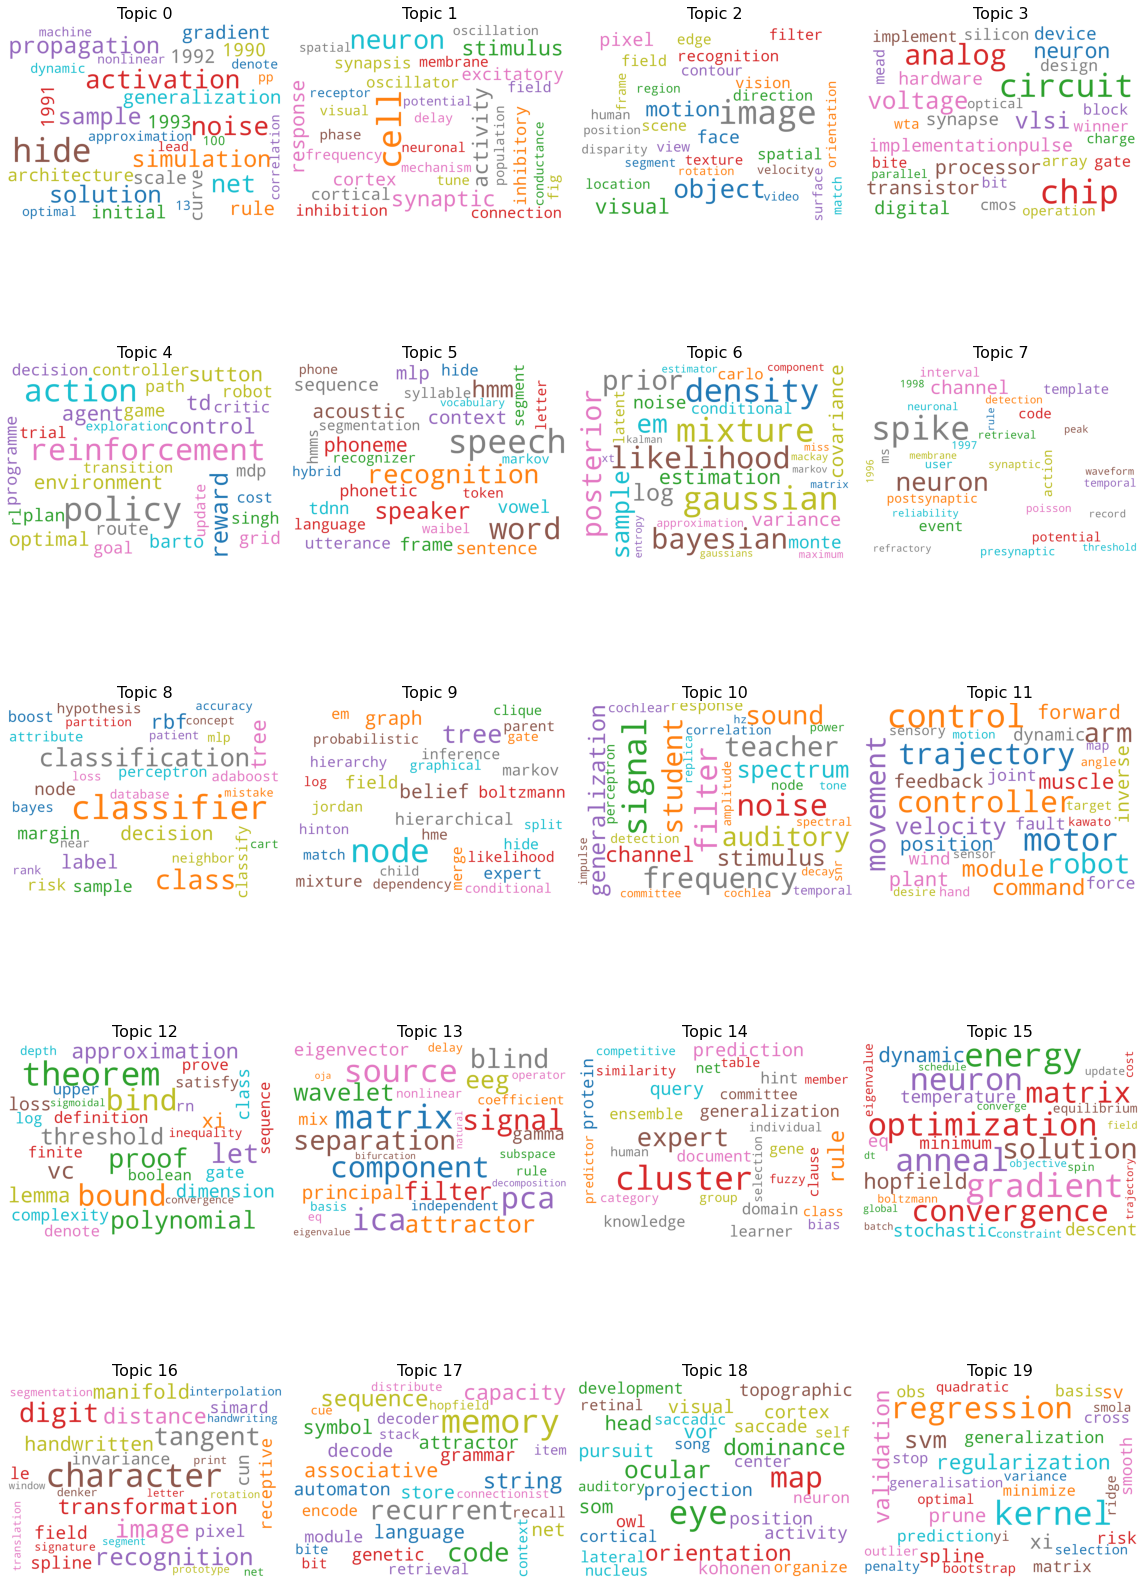

In [32]:
fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 04 scikit-learnのLDAでトピック抽出

### LDAによるトピック抽出の実行

In [33]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [ ]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=1740 and n_features=9523
iteration: 1 of max_iter: 20, perplexity: 3757.5115
iteration: 2 of max_iter: 20, perplexity: 3453.8655
iteration: 3 of max_iter: 20, perplexity: 3276.5438
iteration: 4 of max_iter: 20, perplexity: 3142.0168
iteration: 5 of max_iter: 20, perplexity: 3030.8090
iteration: 6 of max_iter: 20, perplexity: 2935.3267
iteration: 7 of max_iter: 20, perplexity: 2852.1615


### LDAの各トピックから高確率語を取り出す

In [ ]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [ ]:
print(top_words[0])

In [ ]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [ ]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

### pyLDAvisという可視化ツールでトピックを可視化
* https://pyldavis.readthedocs.io/en/latest/

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

## 05 gensimのLDAでトピック抽出

* gensimのLdaModelはデフォルトの設定だと正しく動かない
 * passesを20ぐらいにはしておくこと。
 * 下記Webページは使い方を間違っているので要注意（passesをデフォルト設定で使っている）
 http://www.ie110704.net/2018/12/29/wordcloud%E3%81%A8pyldavis%E3%81%AB%E3%82%88%E3%82%8Blda%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/
* gensimのperplexityはトークンあたりのELBOのnp.exp2()で求めている
 * 自然対数の底を使って求めたELBOをもとにして計算しているにもかかわらず。


In [ ]:
from gensim import corpora

In [ ]:
dictionary = corpora.Dictionary(new_docs)

In [ ]:
print(dictionary)

In [ ]:
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [ ]:
len(dictionary)

In [ ]:
gs_corpus = [dictionary.doc2bow(doc) for doc in new_docs]

In [ ]:
print(gs_corpus[0])

In [ ]:
import logging

logging.basicConfig(filename='myapp.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from gensim.models.ldamodel import LdaModel

In [ ]:
lda = LdaModel(corpus=gs_corpus, num_topics=n_components,
               passes=20)

In [ ]:
import numpy as np

np.exp(- lda.log_perplexity(gs_corpus))